In [20]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, col, avg, sum, count, stddev
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [215]:
def plot3d(x,y,z,pred,title='Title'):
    fig = plt.figure()
    ax = Axes3D(fig)

    ax.scatter(x, y, z, label='Delay')
    ax.scatter(x, y, pred, label='Predictions', c='red')

    ax.set_title(title)
    ax.set_xlabel('Number of flights')
    ax.set_ylabel('Number of cases')
    ax.set_zlabel('Average departure delay')
    fig.legend(bbox_to_anchor=(0.3, 0.8))
    
    plt.savefig(f"plots/{title}.png", dpi=600)
    fig.show()
    
    
def plot(x,y,pred,title='Title'):
    fig = plt.figure()
    ax = plt.axes()
    
    ax.scatter(x, y, label='Delay')
    ax.scatter(x, pred, label='Predictions', c='red')
    
    ax.set_title(title)
    ax.set_xlabel('Number of cases')
    ax.set_ylabel('Average departure delay')
    fig.legend(bbox_to_anchor=(0.905, 0.89))
    
    plt.savefig(f"plots/{title}.png", dpi=600)
    fig.show()

In [2]:
spark = SparkSession.builder.master('local[*]').getOrCreate()

In [3]:
flights_file = spark.read.load('2020.csv', format='csv', inferSchema='true', header='true') \
            .withColumn("FL_DATE", expr("to_date(FL_DATE)"))

cases_file = spark.read.load('cases.csv', format='csv', inferSchema='true', header='true') \
            .withColumn("date", expr("to_date(date)"))

In [171]:
# flights_file = spark.read.load('head_2020.csv', format='csv', inferSchema='true', header='true') \
#             .withColumn("FL_DATE", expr("to_date(FL_DATE)"))

# cases_file = spark.read.load('test_cases.csv', format='csv', inferSchema='true', header='true') \
#             .withColumn("date", expr("to_date(date)"))

In [18]:
flights = flights_file.select(col("FL_DATE").alias("date"), 
                              col("DEP_DELAY").alias("delay"))

flights = flights.groupBy("date").agg(avg("delay").alias("avg_delay"),
                                      stddev("delay").alias("delay_dev"),
                                      count("delay").alias("n_flights"))

In [5]:
cases = cases_file.groupBy("date") \
            .agg(sum("cases").alias("cases")) \
            .where(col("cases") > 100)

In [6]:
df = cases.join(flights, 'date')

# Simple feature vector

In [90]:
va = VectorAssembler(inputCols=['cases'], outputCol='features')
v_df = va.transform(df)

In [91]:
train_df, test_df = v_df.randomSplit([0.7, 0.3])

In [92]:
x = test_df.select('cases').collect()
y = test_df.select('avg_delay').collect()

### Linear regression

In [93]:
lr = LinearRegression(featuresCol = 'features', labelCol='avg_delay', 
                      maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)

In [94]:
lr_predictions = lr_model.transform(test_df)
lr_evaluator = RegressionEvaluator(predictionCol="prediction", 
                                   labelCol="avg_delay",
                                   metricName="rmse")

Root Mean Squared Error (RMSE) on test data = 2.30835


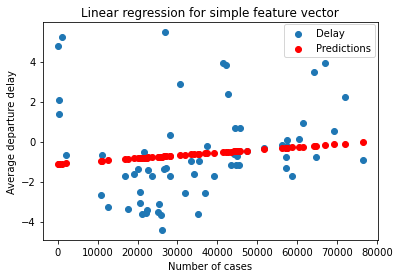

In [209]:
print("Root Mean Squared Error (RMSE) on test data = %g" % lr_evaluator.evaluate(lr_predictions))
plot(x, y, 
     lr_predictions.select('prediction').collect(), 
     'Linear regression for simple feature vector')

### Decision tree regression

In [117]:
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'avg_delay')
dt_model = dt.fit(train_df)

In [118]:
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(labelCol="avg_delay", 
                                   predictionCol="prediction", 
                                   metricName="rmse")

Root Mean Squared Error (RMSE) on test data = 1.88957


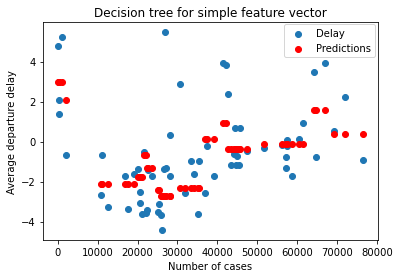

In [210]:
print("Root Mean Squared Error (RMSE) on test data = %g" % dt_evaluator.evaluate(dt_predictions))
plot(x, y, 
     dt_predictions.select('prediction').collect(), 
     'Decision tree for simple feature vector')

### Gradient-boosted tree regression

In [124]:
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'avg_delay', 
                   maxIter=10)
gbt_model = gbt.fit(train_df)

In [125]:
gbt_predictions = gbt_model.transform(test_df)
gbt_evaluator = RegressionEvaluator(labelCol="avg_delay", 
                                    predictionCol="prediction", 
                                    metricName="rmse")

Root Mean Squared Error (RMSE) on test data = 1.92657


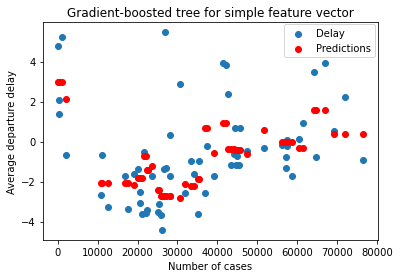

In [211]:
print("Root Mean Squared Error (RMSE) on test data = %g" % gbt_evaluator.evaluate(gbt_predictions))
plot(x, y, 
     gbt_predictions.select('prediction').collect(), 
     'Gradient-boosted tree for simple feature vector')

# Complex feature vector

In [153]:
cva = VectorAssembler(inputCols=['n_flights', 'cases'], outputCol='features')
cv_df = cva.transform(df)

In [154]:
c_train_df, c_test_df = cv_df.randomSplit([0.7, 0.3])

In [155]:
cx = c_test_df.select('n_flights').collect()
cy = c_test_df.select('cases').collect()
cz = c_test_df.select('avg_delay').collect()

### Linear regression

In [160]:
clr = LinearRegression(featuresCol = 'features', labelCol='avg_delay', 
                       maxIter=10, regParam=0.3, elasticNetParam=0.8)
clr_model = clr.fit(c_train_df)

In [161]:
clr_predictions = clr_model.transform(c_test_df)
clr_evaluator = RegressionEvaluator(predictionCol="prediction",
                                    labelCol="avg_delay",
                                    metricName="rmse")

Root Mean Squared Error (RMSE) on test data = 2.43842


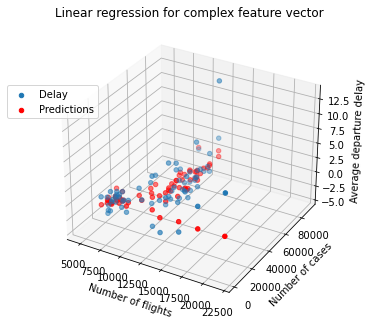

In [212]:
print("Root Mean Squared Error (RMSE) on test data = %g" % clr_evaluator.evaluate(clr_predictions))
plot3d(cx, cy, cz, 
       clr_predictions.select('prediction').collect(), 
       'Linear regression for complex feature vector')

### Decision tree regression

In [156]:
cdt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'avg_delay')
cdt_model = cdt.fit(c_train_df)

In [157]:
cdt_predictions = cdt_model.transform(c_test_df)
cdt_evaluator = RegressionEvaluator(labelCol="avg_delay", 
                                    predictionCol="prediction", 
                                    metricName="rmse")

Root Mean Squared Error (RMSE) on test data = 2.60392


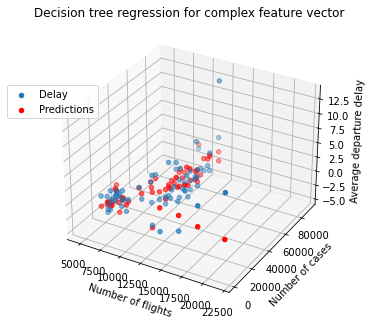

In [213]:
print("Root Mean Squared Error (RMSE) on test data = %g" % cdt_evaluator.evaluate(cdt_predictions))
plot3d(cx, cy, cz, 
       cdt_predictions.select('prediction').collect(), 
       'Decision tree regression for complex feature vector')

### Gradient-boosted tree regression

In [163]:
cgbt = GBTRegressor(featuresCol = 'features', labelCol = 'avg_delay', 
                   maxIter=10)
cgbt_model = cgbt.fit(c_train_df)

In [164]:
cgbt_predictions = cgbt_model.transform(c_test_df)
cgbt_evaluator = RegressionEvaluator(labelCol="avg_delay", 
                                    predictionCol="prediction", 
                                    metricName="rmse")

Root Mean Squared Error (RMSE) on test data = 2.7085


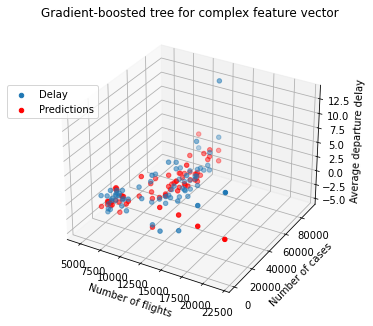

In [214]:
print("Root Mean Squared Error (RMSE) on test data = %g" % cgbt_evaluator.evaluate(cgbt_predictions))
plot3d(cx, cy, cz,
     cgbt_predictions.select('prediction').collect(), 
     'Gradient-boosted tree for complex feature vector')